In [1]:
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error
import datetime

# misc
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

#from prophet import Prophet

In [2]:
df = pd.read_csv('./data/Top100_prediction_con.csv')
print(df.shape)
df.sample(5)

(1739323, 12)


,Unnamed: 0,id,store,date,sales,item,store_code,yearweek,sell_price,weekday,event,income
27992,1377106,SUPERMARKET_2_181_NYC_2,Harlem,2011-03-15,4,SUPERMARKET_2_181,NYC_2,201111,2.604,Tuesday,0.0,10.416
1116852,39281336,HOME_&_GARDEN_1_514_NYC_4,Brooklyn,2014-08-09,2,HOME_&_GARDEN_1_514,NYC_4,201431,4.375,Saturday,0.0,8.750
504043,19720801,SUPERMARKET_3_694_PHI_1,Midtown_Village,2012-11-05,24,SUPERMARKET_3_694,PHI_1,201245,1.896,Monday,0.0,45.504
858411,31236270,SUPERMARKET_3_090_BOS_1,South_End,2013-11-18,0,SUPERMARKET_3_090,BOS_1,201345,1.200,Monday,0.0,0.000
1268214,43947960,SUPERMARKET_3_499_NYC_4,Brooklyn,2015-01-09,1,SUPERMARKET_3_499,NYC_4,201501,3.000,Friday,0.0,3.000


In [3]:
df_products_store = df[['id','item','date','sales','weekday','event']]
ts_test = df_products_store[df_products_store['id']=='SUPERMARKET_3_586_NYC_3']
ts_predict =ts_test[['date','sales']]
ts_predict.sort_values('date', ascending=True, inplace=True)
ts_predict.set_index('date', inplace=True)


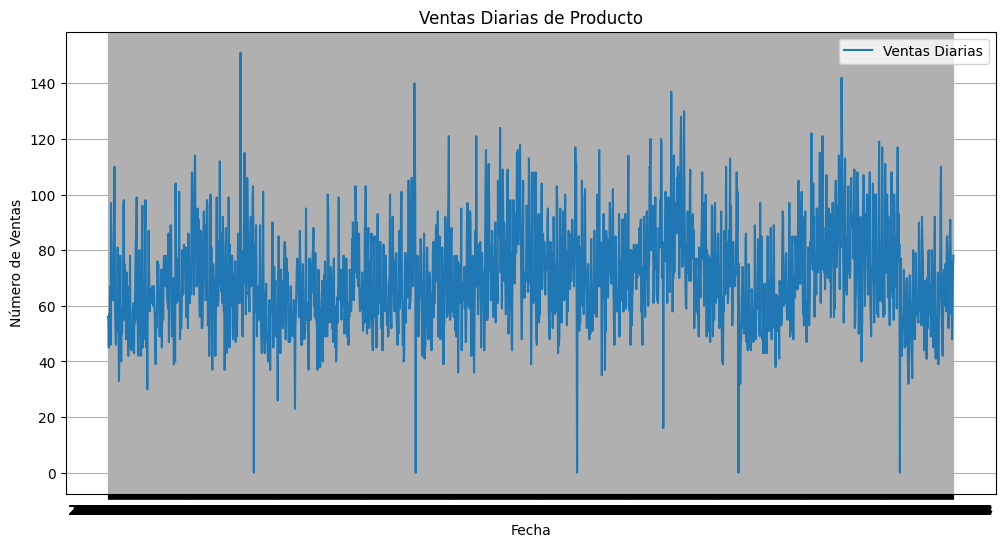

In [8]:
import matplotlib.pyplot as plt

# Graficar la serie temporal
plt.figure(figsize=(12, 6))
plt.plot(ts_predict.index, ts_predict['sales'], label='Ventas Diarias')
plt.xlabel('Fecha')
plt.ylabel('Número de Ventas')
plt.title('Ventas Diarias de Producto')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts_predict['sales'])
print(f'Estadístico ADF: {result[0]}')
print(f'Valor p: {result[1]}')

Estadístico ADF: -4.065037704452121
Valor p: 0.0011057429100135617


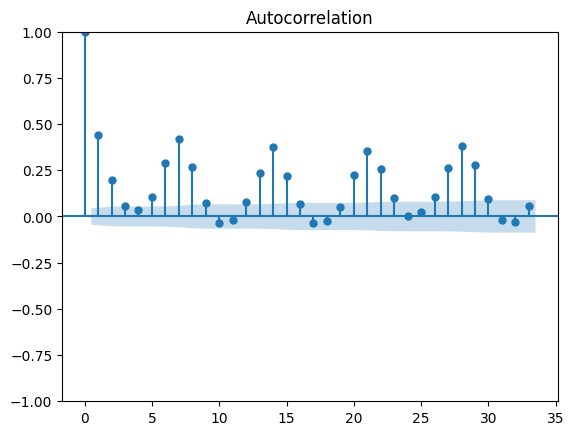

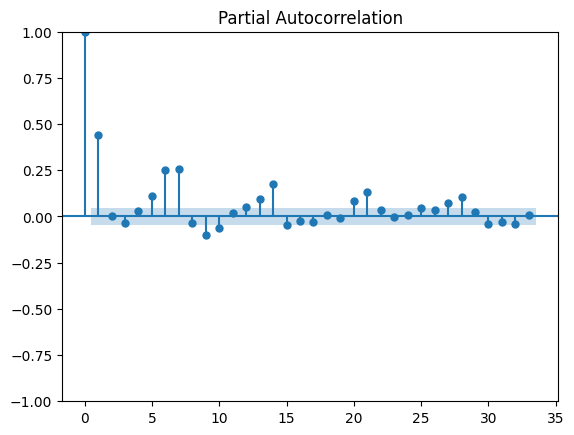

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_predict)
plt.show()

plot_pacf(ts_predict)
plt.show()

In [7]:
y_train, y_test = ts_predict[:-53], ts_predict[-53:]
y_future_predict= ts_predict[-24:]

In [8]:
pdq = [
    (1, 0, 1), (1, 0, 2),
    (1, 0, 5), (1, 0, 6),
    (5, 0, 1), (5, 0, 2),
    (5, 0, 5), (5, 0, 6),
    (6, 0, 1), (6, 0, 2),
    (6, 0, 5), (6, 0, 6),

    
    
    # Opciones con d = 1 (por si acaso)
    # (1, 1, 1), (1, 1, 2),
    # (2, 1, 1), (2, 1, 2)

    (1, 1, 1), (1, 1, 2),
    (2, 1, 3), (2, 1, 4),
    (2, 1, 5), (2, 1, 1),
    (2, 1, 2), (2, 1, 3),
    (2, 1, 4), (2, 1, 5)
]

# Probar también con algún P o Q diferente de 0 en la parte estacional
seasonal_pdq = (0, 1, 0, 7) # Actual
#     (1, 1, 0, 7),  # AR estacional
#     (0, 1, 1, 7),  # MA estacional
#     (1, 1, 1, 7)   # AR y MA estacional

In [15]:
RESULTS_DICT = {}

for param in pdq:

    model = sm.tsa.statespace.SARIMAX(
        endog = y_train,
        order = param,
        seasonal_order = seasonal_pdq,
        enforce_stationarity = False,
        enforce_invertibility = False
    )

    model_fitted = model.fit()

    print('ARIMA{}x{}12 - AIC:{}'.format(param, seasonal_pdq, model_fitted.aic))

    RESULTS_DICT[param] = round(model_fitted.aic, 2)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.30657D+00    |proj g|=  1.43417D-02

At iterate    5    f=  4.30578D+00    |proj g|=  4.44970D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   2.991D-06   4.306D+00
  F =   4.3057821610387874     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


ARIMA(1, 0, 1)x(0, 1, 0, 7)12 - AIC:16023.50963906429
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.30289D+00    |proj g|=  1.09578D-02

At iterate    5    f=  4.30260D+00    |proj g|=  2.42909D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   1.205D-05   4.303D+00
  F =   4.3025901895071783     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2)x(0, 1, 0, 7)12 - AIC:16013.635504966704
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29464D+00    |proj g|=  5.68263D-02


 This problem is unconstrained.



At iterate    5    f=  4.28243D+00    |proj g|=  5.04340D-02

At iterate   10    f=  4.27687D+00    |proj g|=  3.36287D-02

At iterate   15    f=  4.27603D+00    |proj g|=  1.83619D-03

At iterate   20    f=  4.27472D+00    |proj g|=  3.99860D-02

At iterate   25    f=  4.27437D+00    |proj g|=  1.77131D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     44      1     0     0   7.841D-05   4.274D+00
  F =   4.2743721752284198     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 5)x(0, 1, 0, 7)12 - AIC:15914.66449184972
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  4.21172D+00    |proj g|=  4.30689D-01

At iterate   10    f=  4.16625D+00    |proj g|=  3.43503D-01

At iterate   15    f=  4.15545D+00    |proj g|=  5.68600D-02

At iterate   20    f=  4.14535D+00    |proj g|=  6.68018D-02

At iterate   25    f=  4.14173D+00    |proj g|=  4.87387D-02

At iterate   30    f=  4.14127D+00    |proj g|=  2.38561D-02

At iterate   35    f=  4.13922D+00    |proj g|=  2.32153D-01

At iterate   40    f=  4.12829D+00    |proj g|=  1.62493D-01

At iterate   45    f=  4.12148D+00    |proj g|=  1.59673D-01

At iterate   50    f=  4.11789D+00    |proj g|=  2.31960D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.29246D+00    |proj g|=  1.36321D-01

At iterate   10    f=  4.27463D+00    |proj g|=  1.89311D-02

At iterate   15    f=  4.27408D+00    |proj g|=  2.29060D-03

At iterate   20    f=  4.27378D+00    |proj g|=  1.33059D-02

At iterate   25    f=  4.27363D+00    |proj g|=  5.51903D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     45      1     0     0   1.160D-05   4.274D+00
  F =   4.2736279953146363     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(5, 0, 1)x(0, 1, 0, 7)12 - AIC:15911.896142570447
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  4.43246D+00    |proj g|=  3.16806D-01

At iterate   10    f=  4.26697D+00    |proj g|=  6.57197D-02

At iterate   15    f=  4.26252D+00    |proj g|=  8.43885D-03

At iterate   20    f=  4.26079D+00    |proj g|=  6.07907D-02

At iterate   25    f=  4.24860D+00    |proj g|=  1.04160D-01

At iterate   30    f=  4.24613D+00    |proj g|=  5.76498D-03

At iterate   35    f=  4.24611D+00    |proj g|=  8.30100D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     47      1     0     0   8.301D-05   4.246D+00
  F =   4.2461130038308266     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.26915D+00    |proj g|=  8.32151D-02

At iterate   10    f=  4.25125D+00    |proj g|=  9.62691D-02

At iterate   15    f=  4.21698D+00    |proj g|=  5.15724D-01

At iterate   20    f=  4.20911D+00    |proj g|=  4.76466D-02

At iterate   25    f=  4.20702D+00    |proj g|=  1.71900D-02

At iterate   30    f=  4.19919D+00    |proj g|=  2.39809D-01

At iterate   35    f=  4.17971D+00    |proj g|=  2.39779D-01

At iterate   40    f=  4.16268D+00    |proj g|=  2.07429D-01

At iterate   45    f=  4.16059D+00    |proj g|=  1.26359D-01

At iterate   50    f=  4.15919D+00    |proj g|=  4.51633D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.21595D+00    |proj g|=  1.20322D-01

At iterate   10    f=  4.18863D+00    |proj g|=  4.01428D-02

At iterate   15    f=  4.18045D+00    |proj g|=  4.45075D-02

At iterate   20    f=  4.16933D+00    |proj g|=  5.42148D-02

At iterate   25    f=  4.15532D+00    |proj g|=  7.28013D-02

At iterate   30    f=  4.14383D+00    |proj g|=  3.31457D-01

At iterate   35    f=  4.12583D+00    |proj g|=  1.64904D-01

At iterate   40    f=  4.10560D+00    |proj g|=  7.10712D-02

At iterate   45    f=  4.10057D+00    |proj g|=  1.17891D-01

At iterate   50    f=  4.09823D+00    |proj g|=  3.29727D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.29275D+00    |proj g|=  3.38296D-02

At iterate   10    f=  4.26437D+00    |proj g|=  1.22541D-01

At iterate   15    f=  4.26209D+00    |proj g|=  5.62669D-02

At iterate   20    f=  4.26046D+00    |proj g|=  2.93803D-02

At iterate   25    f=  4.26026D+00    |proj g|=  9.71439D-03

At iterate   30    f=  4.26019D+00    |proj g|=  9.18767D-03

At iterate   35    f=  4.25957D+00    |proj g|=  3.22591D-02

At iterate   40    f=  4.25916D+00    |proj g|=  8.17755D-03

At iterate   45    f=  4.25911D+00    |proj g|=  6.57909D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     68   

 This problem is unconstrained.



At iterate    5    f=  4.28625D+00    |proj g|=  1.32553D-01

At iterate   10    f=  4.26704D+00    |proj g|=  2.33553D-01

At iterate   15    f=  4.25298D+00    |proj g|=  5.90531D-02

At iterate   20    f=  4.25012D+00    |proj g|=  3.23073D-02

At iterate   25    f=  4.24909D+00    |proj g|=  1.21690D-02

At iterate   30    f=  4.24669D+00    |proj g|=  4.52166D-02

At iterate   35    f=  4.24346D+00    |proj g|=  2.51996D-02

At iterate   40    f=  4.24313D+00    |proj g|=  2.16813D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     65      1     0     0   1.155D-04   4.243D+00
  F =   4.24312498331

 This problem is unconstrained.



At iterate    5    f=  4.25828D+00    |proj g|=  1.15953D-01

At iterate   10    f=  4.24760D+00    |proj g|=  1.32266D-02

At iterate   15    f=  4.24246D+00    |proj g|=  4.32908D-02

At iterate   20    f=  4.23068D+00    |proj g|=  4.83931D-02

At iterate   25    f=  4.20241D+00    |proj g|=  1.61233D-01

At iterate   30    f=  4.18726D+00    |proj g|=  2.85605D-01

At iterate   35    f=  4.15794D+00    |proj g|=  3.75436D-01

At iterate   40    f=  4.15268D+00    |proj g|=  8.70220D-02

At iterate   45    f=  4.15133D+00    |proj g|=  3.94355D-02

At iterate   50    f=  4.15047D+00    |proj g|=  3.87025D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.17739D+00    |proj g|=  1.31051D-01

At iterate   10    f=  4.15858D+00    |proj g|=  1.10727D-01

At iterate   15    f=  4.13683D+00    |proj g|=  9.89515D-02

At iterate   20    f=  4.13170D+00    |proj g|=  3.39498D-02

At iterate   25    f=  4.13059D+00    |proj g|=  2.27565D-02

At iterate   30    f=  4.12756D+00    |proj g|=  1.49256D-01

At iterate   35    f=  4.12430D+00    |proj g|=  8.68077D-02

At iterate   40    f=  4.12095D+00    |proj g|=  1.16903D-01

At iterate   45    f=  4.11702D+00    |proj g|=  3.05741D-02

At iterate   50    f=  4.11524D+00    |proj g|=  8.39574D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.33089D+00    |proj g|=  3.85276D-01

At iterate   10    f=  4.31801D+00    |proj g|=  1.28975D-02

At iterate   15    f=  4.31677D+00    |proj g|=  7.07567D-02

At iterate   20    f=  4.31278D+00    |proj g|=  1.17784D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     38      1     0     0   5.915D-08   4.313D+00
  F =   4.3127788889836927     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 0, 7)12 - AIC:16049.537467019338
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  4.98010D+00    |proj g|=  2.85878D-01

At iterate   10    f=  4.33587D+00    |proj g|=  6.13491D-01

At iterate   15    f=  4.30355D+00    |proj g|=  1.88566D-02

At iterate   20    f=  4.30347D+00    |proj g|=  7.50986D-04

At iterate   25    f=  4.30346D+00    |proj g|=  2.06903D-02

At iterate   30    f=  4.30345D+00    |proj g|=  3.92218D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     63      1     0     0   7.456D-04   4.303D+00
  F =   4.3034452016935774     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(0, 1, 0, 7)12 - AIC:16016.816150300

 This problem is unconstrained.



At iterate    5    f=  4.34150D+00    |proj g|=  4.53260D-01

At iterate   10    f=  4.30109D+00    |proj g|=  3.74156D-01

At iterate   15    f=  4.29705D+00    |proj g|=  1.64225D-01

At iterate   20    f=  4.25223D+00    |proj g|=  3.90272D-01

At iterate   25    f=  4.24833D+00    |proj g|=  1.36822D-01

At iterate   30    f=  4.24820D+00    |proj g|=  7.29509D-03

At iterate   35    f=  4.24796D+00    |proj g|=  5.31240D-02

At iterate   40    f=  4.24417D+00    |proj g|=  1.63679D-01

At iterate   45    f=  4.24355D+00    |proj g|=  1.94289D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     61   

 This problem is unconstrained.



At iterate    5    f=  4.30491D+00    |proj g|=  6.32762D-02

At iterate   10    f=  4.29762D+00    |proj g|=  1.54735D-01

At iterate   15    f=  4.25132D+00    |proj g|=  3.03495D-01

At iterate   20    f=  4.24522D+00    |proj g|=  2.11071D-02

At iterate   25    f=  4.24498D+00    |proj g|=  5.25797D-02

At iterate   30    f=  4.24153D+00    |proj g|=  8.08608D-02

At iterate   35    f=  4.23806D+00    |proj g|=  1.01348D-01

At iterate   40    f=  4.23207D+00    |proj g|=  9.42805D-02

At iterate   45    f=  4.23098D+00    |proj g|=  3.58799D-02

At iterate   50    f=  4.23095D+00    |proj g|=  6.84324D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.29882D+00    |proj g|=  7.56885D-02

At iterate   10    f=  4.29522D+00    |proj g|=  6.17365D-02

At iterate   15    f=  4.27638D+00    |proj g|=  1.76031D-01

At iterate   20    f=  4.25133D+00    |proj g|=  1.61786D-01

At iterate   25    f=  4.24466D+00    |proj g|=  3.34173D-02

At iterate   30    f=  4.24426D+00    |proj g|=  1.32263D-02

At iterate   35    f=  4.23798D+00    |proj g|=  2.31329D-01

At iterate   40    f=  4.21973D+00    |proj g|=  2.57776D-01

At iterate   45    f=  4.21402D+00    |proj g|=  1.04168D-01

At iterate   50    f=  4.21375D+00    |proj g|=  1.86025D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.34091D+00    |proj g|=  4.12407D-01

At iterate   10    f=  4.31263D+00    |proj g|=  3.09453D-01

At iterate   15    f=  4.31207D+00    |proj g|=  7.09500D-02

At iterate   20    f=  4.31190D+00    |proj g|=  9.52723D-02

At iterate   25    f=  4.30891D+00    |proj g|=  4.46567D-01

At iterate   30    f=  4.30592D+00    |proj g|=  2.36140D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     60      1     0     0   3.515D-05   4.306D+00
  F =   4.3058955864312507     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(0, 1, 0, 7)12 - AIC:16025.931581524

 This problem is unconstrained.



At iterate    5    f=  5.00769D+00    |proj g|=  4.34317D-01

At iterate   10    f=  4.39648D+00    |proj g|=  6.17056D-01

At iterate   15    f=  4.37164D+00    |proj g|=  1.94848D+00

At iterate   20    f=  4.29881D+00    |proj g|=  8.25713D+00

At iterate   25    f=  4.29594D+00    |proj g|=  9.06913D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     68      1     0     0   2.608D-01   4.296D+00
  F =   4.2959070201209277     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(0, 1, 0, 7)12 - AIC:15990.77411484985
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  4.34150D+00    |proj g|=  4.53260D-01

At iterate   10    f=  4.30109D+00    |proj g|=  3.74156D-01

At iterate   15    f=  4.29705D+00    |proj g|=  1.64225D-01

At iterate   20    f=  4.25223D+00    |proj g|=  3.90272D-01

At iterate   25    f=  4.24833D+00    |proj g|=  1.36822D-01

At iterate   30    f=  4.24820D+00    |proj g|=  7.29509D-03

At iterate   35    f=  4.24796D+00    |proj g|=  5.31240D-02

At iterate   40    f=  4.24417D+00    |proj g|=  1.63679D-01

At iterate   45    f=  4.24355D+00    |proj g|=  1.94289D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     61   

 This problem is unconstrained.



At iterate    5    f=  4.30491D+00    |proj g|=  6.32762D-02

At iterate   10    f=  4.29762D+00    |proj g|=  1.54735D-01

At iterate   15    f=  4.25132D+00    |proj g|=  3.03495D-01

At iterate   20    f=  4.24522D+00    |proj g|=  2.11071D-02

At iterate   25    f=  4.24498D+00    |proj g|=  5.25797D-02

At iterate   30    f=  4.24153D+00    |proj g|=  8.08608D-02

At iterate   35    f=  4.23806D+00    |proj g|=  1.01348D-01

At iterate   40    f=  4.23207D+00    |proj g|=  9.42805D-02

At iterate   45    f=  4.23098D+00    |proj g|=  3.58799D-02

At iterate   50    f=  4.23095D+00    |proj g|=  6.84324D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.29882D+00    |proj g|=  7.56885D-02

At iterate   10    f=  4.29522D+00    |proj g|=  6.17365D-02

At iterate   15    f=  4.27638D+00    |proj g|=  1.76031D-01

At iterate   20    f=  4.25133D+00    |proj g|=  1.61786D-01

At iterate   25    f=  4.24466D+00    |proj g|=  3.34173D-02

At iterate   30    f=  4.24426D+00    |proj g|=  1.32263D-02

At iterate   35    f=  4.23798D+00    |proj g|=  2.31329D-01

At iterate   40    f=  4.21973D+00    |proj g|=  2.57776D-01

At iterate   45    f=  4.21402D+00    |proj g|=  1.04168D-01

At iterate   50    f=  4.21375D+00    |proj g|=  1.86025D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [16]:
gsx = list(map(str, list(RESULTS_DICT.keys())))
gsy = list(RESULTS_DICT.values())

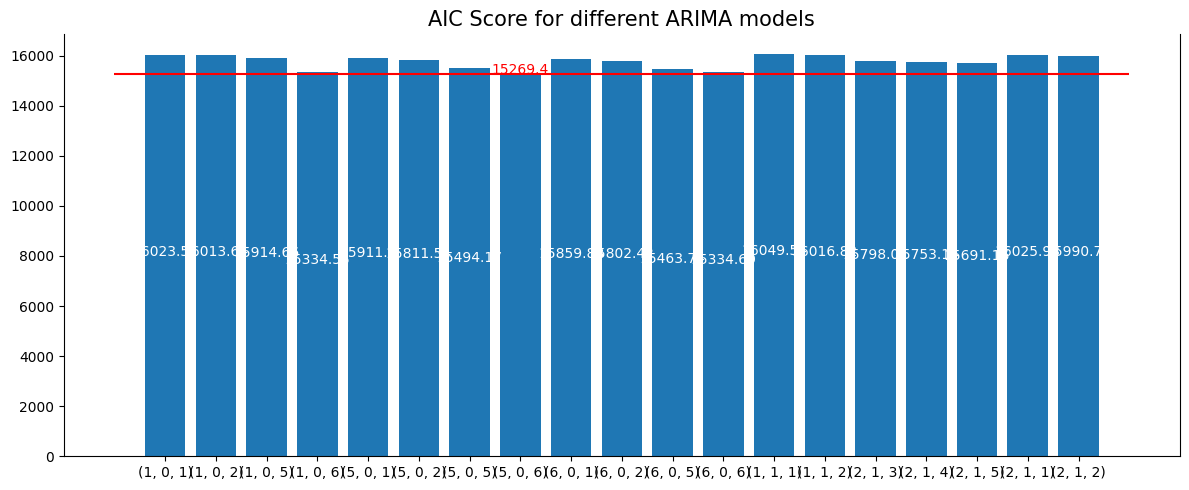

In [17]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot()

ax.bar(x = gsx, height = gsy)
ax.hlines(y = min(gsy), xmin = -1, xmax = len(gsx), color = "red")

for xtick_, y_ in zip(gsx, gsy):

    s_ = str(round(y_, 2))

    ax.text(
        x = xtick_,
        y = y_/2 if y_ != min(gsy) else y_ + 10,
        s = s_,
        ha = "center",
        color = "red" if y_ == min(gsy) else "white"
    )

ax.spines["top"].set_color("None")

plt.title(label = "AIC Score for different ARIMA models", fontsize = 15)
plt.tight_layout()

In [18]:
RESULTS_DICT

{(1, 0, 1): 16023.51,
 (1, 0, 2): 16013.64,
 (1, 0, 5): 15914.66,
 (1, 0, 6): 15334.55,
 (5, 0, 1): 15911.9,
 (5, 0, 2): 15811.54,
 (5, 0, 5): 15494.17,
 (5, 0, 6): 15269.4,
 (6, 0, 1): 15859.88,
 (6, 0, 2): 15802.42,
 (6, 0, 5): 15463.74,
 (6, 0, 6): 15334.69,
 (1, 1, 1): 16049.54,
 (1, 1, 2): 16016.82,
 (2, 1, 3): 15798.01,
 (2, 1, 4): 15753.14,
 (2, 1, 5): 15691.16,
 (2, 1, 1): 16025.93,
 (2, 1, 2): 15990.77}

In [19]:
idx_min_score_aic = np.argmin(list(RESULTS_DICT.values()))
pdq_min_score_aic = list(RESULTS_DICT.keys())[idx_min_score_aic]
min_score_aic = RESULTS_DICT[pdq_min_score_aic]

message = f'''
El score mínimo se alcanza con ARIMA{pdq_min_score_aic}
Con un score AIC de {min_score_aic}.
En la posición {idx_min_score_aic}
'''

print(message)


El score mínimo se alcanza con ARIMA(5, 0, 6)
Con un score AIC de 15269.4.
En la posición 7



In [9]:
best_arima_model = sm.tsa.statespace.SARIMAX(
    endog = y_train,
    order = (5,0,6),
    seasonal_order = seasonal_pdq,
    enforce_stationarity = False,
    enforce_invertibility = False
)

best_arima_model_fitted = best_arima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.25868D+00    |proj g|=  1.31424D-01


 This problem is unconstrained.



At iterate    5    f=  4.21595D+00    |proj g|=  1.20322D-01

At iterate   10    f=  4.18863D+00    |proj g|=  4.01428D-02

At iterate   15    f=  4.18045D+00    |proj g|=  4.45075D-02

At iterate   20    f=  4.16933D+00    |proj g|=  5.42148D-02

At iterate   25    f=  4.15532D+00    |proj g|=  7.28013D-02

At iterate   30    f=  4.14383D+00    |proj g|=  3.31457D-01

At iterate   35    f=  4.12583D+00    |proj g|=  1.64904D-01

At iterate   40    f=  4.10560D+00    |proj g|=  7.10712D-02

At iterate   45    f=  4.10057D+00    |proj g|=  1.17891D-01

At iterate   50    f=  4.09823D+00    |proj g|=  3.29727D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [21]:
print(best_arima_model_fitted.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7245      0.043    -16.715      0.000      -0.809      -0.640
ar.L2         -0.5010      0.062     -8.090      0.000      -0.622      -0.380
ar.L3         -0.2535      0.067     -3.785      0.000      -0.385      -0.122
ar.L4         -0.0797      0.056     -1.431      0.153      -0.189       0.030
ar.L5         -0.0198      0.037     -0.541      0.588      -0.092       0.052
ma.L1          1.1259      0.035     31.877      0.000       1.057       1.195
ma.L2          1.0953      0.065     16.728      0.000       0.967       1.224
ma.L3          0.9155      0.081     11.267      0.000       0.756       1.075
ma.L4          0.7303      0.077      9.427      0.000       0.578       0.882
ma.L5          0.6733      0.057     11.721      0.000       0.561       0.786
ma.L6          0.7803      0.031     25.348      0.0

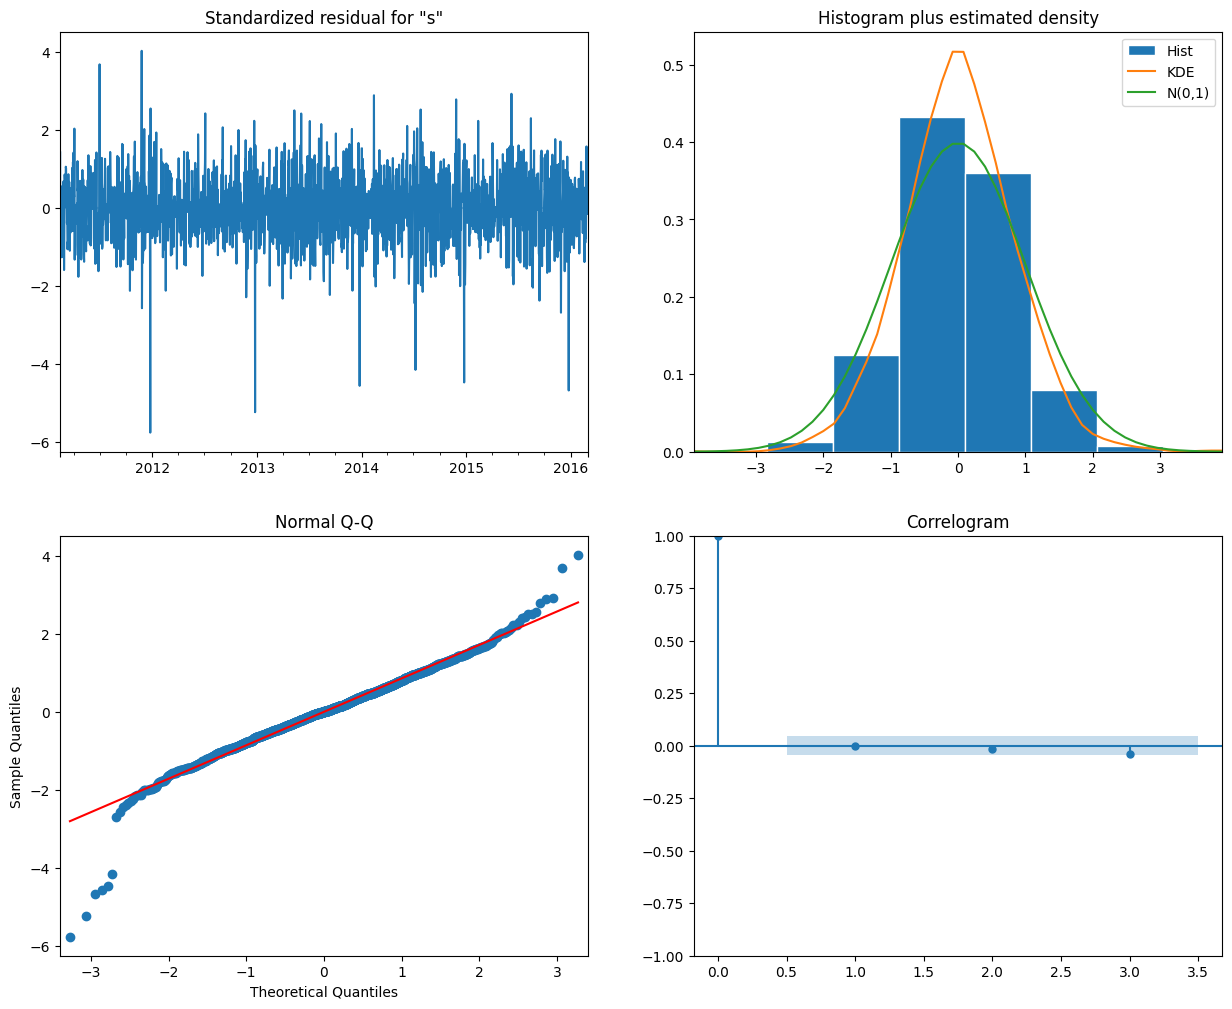

In [22]:
best_arima_model_fitted.plot_diagnostics(figsize = (15, 12), lags = 3);

In [12]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = best_arima_model_fitted.get_forecast(steps = len(y_test))

# 1. Obtener las predicciones puntuales
y_pred = pred_uc.predicted_mean

# 2. Calcular el MSE comparando y_test con y_pred
mse = mean_squared_error(y_test, y_pred)

print(f'El error MSE es: {mse}')

El error MSE es: 126.4337864616289


In [31]:
y_pred_test.name = 'arima_predict'

In [32]:
ts_predict.reset_index(inplace=True)

In [33]:
ts_predict['date'] = pd.to_datetime(ts_predict['date'])

In [34]:
ts_predict.set_index('date', inplace=True)

TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x7faeebf831f0>.

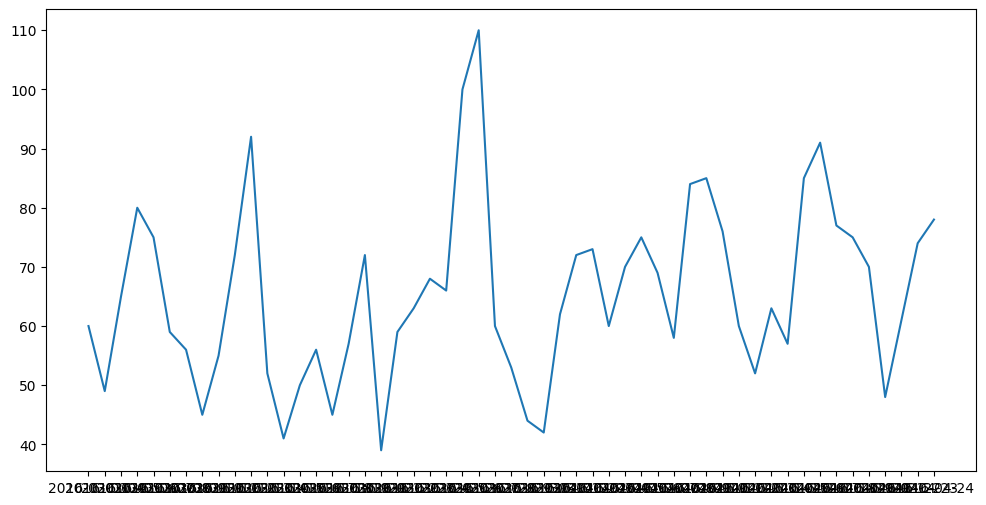

In [13]:
fig = plt.figure(figsize = (12, 6))
ax = fig.subplots()

ax.plot(ts_predict[-53:], label = "True Values")
ax.plot(y_pred, label = "ARIMA Forecast")

ax.legend(loc = "upper left")
fig.suptitle("Lynx Values and ARIMA Forecast", fontsize = 15)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suponiendo que 'y_test' son los valores reales y 'predictions' son los valores predichos
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)  # Con squared=False obtenemos RMSE

# Si prefieres usar MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

# Imprimir los resultados
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')